# Computer Vision

We import `numpy` (as before) and `mahotas` (for image processsing/computer vision):

In [1]:
import numpy as np
import mahotas as mh

Make plots inline:

In [2]:
%matplotlib inline

## Basic image processing
First example:

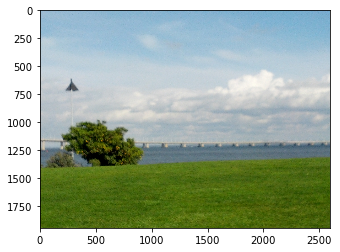

In [3]:
image = mh.imread('scene00.jpg')
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.imshow(image)

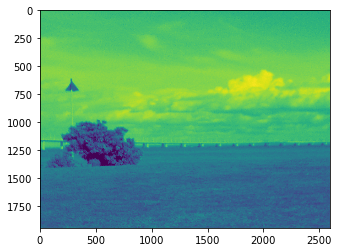

In [4]:
fig, ax = plt.subplots()
image = mh.colors.rgb2grey(image, dtype=np.uint8)
ax.imshow(image)

Otsu threshold is 138.


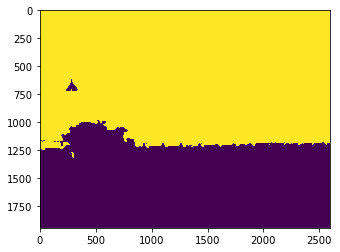

In [5]:
thresh = mh.thresholding.otsu(image)
print('Otsu threshold is {}.'.format(thresh))
# Otsu threshold is 138.
plt.imshow(image > thresh)

Otsu threshold is 137.


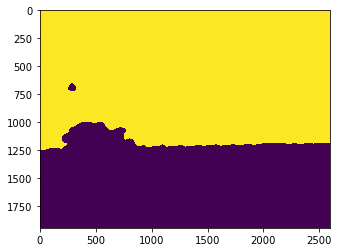

In [6]:
im16 = mh.gaussian_filter(image,16)
thresh = mh.thresholding.otsu(im16.astype(np.uint8))
print('Otsu threshold is {}.'.format(thresh))
# Otsu threshold is 138.
plt.imshow(im16 > thresh)

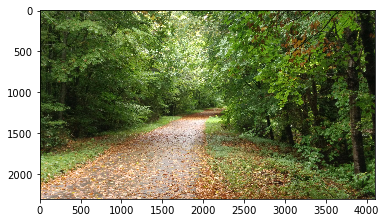

In [7]:
im = mh.imread('forest.jpeg')
fig,ax = plt.subplots()
ax.imshow(im)

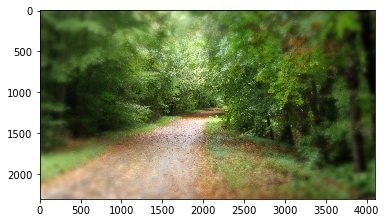

In [8]:
r,g,b = im.transpose(2,0,1) 
r12 = mh.gaussian_filter(r, 24.)
g12 = mh.gaussian_filter(g, 24.)
b12 = mh.gaussian_filter(b, 24.)
im12 = mh.as_rgb(r12,g12,b12)
h, w = r.shape # height and width
Y, X = np.mgrid[:h,:w]
Y = Y-h/2. # center at h/2
Y = Y / Y.max() # normalize to -1 .. +1

X = X-w/2.
X = X / X.max()

C = np.exp(-2.*(X**2+ Y**2))

# Normalize again to 0..1
C = C - C.min()
C = C / C.ptp()
C = C[:,:,None] # This adds a dummy third dimension to C

ringed = mh.stretch(im*C + (1-C)*im12)
fig,ax = plt.subplots()
ax.imshow(ringed)

## Classification

A first peek at the data:

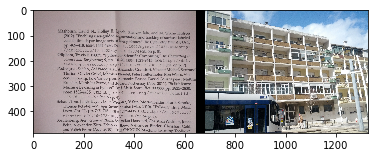

In [9]:
text = mh.imread("../SimpleImageDataset/text21.jpg")
building = mh.imread("../SimpleImageDataset/building00.jpg")
h, w, _ = text.shape
canvas = np.zeros((h, 2 * w + 128, 3), np.uint8)
canvas[:, -w:] = building
canvas[:, :w] = text
canvas = canvas[::4, ::4]
fig, ax = plt.subplots()
ax.imshow(canvas)

For classification, we compute _features_:

In [10]:
from glob import glob

images = glob('../SimpleImageDataset/*.jpg')
features = []
labels = []
for im in images:
    labels.append(im[:-len('00.jpg')])
    im = mh.imread(im)
    im = mh.colors.rgb2gray(im, dtype=np.uint8)
    features.append(mh.features.haralick(im).ravel())

features = np.array(features)
labels = np.array(labels)

Now, we can use a standard classifier from `scikit-learn`:

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
clf = Pipeline([('preproc', StandardScaler()),
                ('classifier', LogisticRegression())])


from sklearn import model_selection
cv = model_selection.LeaveOneOut()
scores = model_selection.cross_val_score(
    clf, features, labels, cv=cv)
print('Accuracy: {:.1%}'.format(scores.mean()))

Accuracy: 81.1%


Let us define our own features:

In [12]:
def chist(im):
    im = im // 64
    r,g,b = im.transpose((2,0,1))
    pixels = 1 * r + 4 * b + 16 * g
    hist = np.bincount(pixels.ravel(), minlength=64)
    hist = hist.astype(float)
    hist = np.log1p(hist)
    return hist

Now, we use these features for classification:

In [13]:
features = []
for im in images:
    imcolor = mh.imread(im)
    im = mh.colors.rgb2gray(imcolor, dtype=np.uint8)
    features.append(np.concatenate([
            mh.features.haralick(im).ravel(),
            chist(imcolor),
        ]))


scores = model_selection.cross_val_score(
    clf, features, labels, cv=cv)
print('Accuracy: {:.1%}'.format(scores.mean()))

Accuracy: 96.7%


Ignore the areas close to the border:

## Nearest neighbor

We re-compute the features, _while ignoring the border areas_:

In [14]:
features = []
for im in images:
    imcolor = mh.imread(im)
    # Ignore everything in the 200 pixels close to the borders
    imcolor = imcolor[200:-200, 200:-200]
    im = mh.colors.rgb2gray(imcolor, dtype=np.uint8)
    features.append(np.concatenate([
          mh.features.haralick(im).ravel(),
          chist(imcolor),
      ]))


Now, we

1. scale the features
2. find nearest neighbors


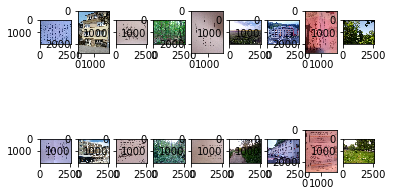

In [15]:
sc = StandardScaler()
features = sc.fit_transform(features)
from scipy.spatial import distance
dists = distance.squareform(distance.pdist(features))


fig, axes = plt.subplots(2, 9)
for ci,i in enumerate(range(0,90,10)):
    left = images[i]
    dists_left = dists[i]
    right = dists_left.argsort()
    # right[0] is the same as left[i], so pick the next closest element
    right = right[1]
    right = images[right]
    left = mh.imread(left)
    right = mh.imread(right)
    axes[0, ci].imshow(left)
    axes[1, ci].imshow(right)

## Larger dataset

First, download the big dataset:

In [16]:
from os import path, system
basedir = 'AnimTransDistr'
if not path.exists(basedir):
    !./download.sh

Compute same features as before:

In [17]:
classes = [
    'Anims',
    'Cars',
    'Distras',
    'Trans',
]

images = []
labels = []
for ci, cl in enumerate(classes):
    current = glob('{}/{}/*.jpg'.format(basedir, cl))
    for im in sorted(current):
        labels.append(cl)
        images.append(im)


print('Computing whole-image texture features [can take a while]...')
ifeatures = []
for im in images:
    im = mh.imread(im)
    img = mh.colors.rgb2grey(im).astype(np.uint8)
    fs = np.concatenate([mh.features.haralick(img).ravel(),
                                chist(im)])
    ifeatures.append(fs)

ifeatures = np.array(ifeatures)
labels = np.array(labels)


Computing whole-image texture features [can take a while]...


We can use these for classification:

In [18]:
from sklearn.model_selection import GridSearchCV
C_range = 10.0 ** np.arange(-4, 3)
grid = GridSearchCV(LogisticRegression(), param_grid={'C' : C_range})
clf = Pipeline([('preproc', StandardScaler()),
               ('classifier', grid)])

cv = model_selection.KFold(n_splits=5,
                     shuffle=True, random_state=123)
scores = model_selection.cross_val_score(
   clf, ifeatures, labels, n_jobs=-1, cv=cv)
print('Accuracy  (5 fold x-val) with Logistic Regression [image features]: {:.1%}'.format(scores.mean()))

Accuracy  (5 fold x-val) with Logistic Regression [image features]: 73.4%


### SURF features


In [19]:
from mahotas.features import surf

alldescriptors = []
print("Computing SURF (this will take a while)")
for im in images:
    im = mh.imread(im, as_grey=True)
    im = im.astype(np.uint8)
    desc = surf.surf(im, descriptor_only=True)
    # To use dense sampling, you can try the following line:
    # desc = surf.dense(im, spacing=16)
    alldescriptors.append(desc)
# get all descriptors into a single array
concatenated = np.concatenate(alldescriptors)

Computing SURF (this will take a while)


Now, compute the k-means structure, using 256 clusters:

In [20]:
print("Total nr descriptors: {}".format(len(concatenated)))
concatenated = concatenated[::64]

Total nr descriptors: 2489095


In [21]:
from sklearn.cluster import KMeans
k = 256
km = KMeans(k)
km.fit(concatenated)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=256, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

We now use the kmean structure on **all the descriptors**:

In [22]:
sfeatures = []

for d in alldescriptors:
    c = km.predict(d)
    sfeatures.append(np.bincount(c, minlength=256))
    
# build single array and convert to float
sfeatures = np.array(sfeatures, dtype=float)
scores = model_selection.cross_val_score(
   clf, sfeatures, labels, cv=cv)
print('Accuracy (5 fold x-val) with Logistic Regression [SURF]: {:.1%}'.format(scores.mean()))

Accuracy (5 fold x-val) with Logistic Regression [SURF]: 62.6%


Combine the features for the final result

In [23]:
allfeatures = np.hstack([sfeatures, ifeatures])
score_SURF_global = model_selection.cross_val_score(
    clf, allfeatures, labels, cv=cv).mean()
print('Accuracy (5 fold x-val) with Logistic Regression [All features]: {:.1%}'.format(
    score_SURF_global.mean()))

Accuracy (5 fold x-val) with Logistic Regression [All features]: 76.7%
